<a href="https://colab.research.google.com/github/Donovanphenry/Hide_And_Seq/blob/model-construction/Hide_And_Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Debug Notice: Find and Squash all `#TODO` mentions!

## Installing Required Libraries

In [1]:
# does this help torch import?
!pip3 install Cython
!pip3 install torch

In [2]:
# installs and magics
!pip install Bio
!pip install pandas
!pip install numpy
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from Bio import SeqIO
import pandas as pd
import numpy as np
import math
# import random

# clear import log garbage
clear_output()

## Download dataset

In [3]:
# downloading dataset
!wget --user=ftp ftp://ccg.epfl.ch/epd/current/epd_16K.seq
clear_output()

## Building DataFrames

## Set seeds

In [4]:
np.random.seed(0)

### Function to generate negative dataset

In [8]:
# generate negative dataset 

def gen_neg_dataset(sequence_string):    
  # create 400 subdivisions 
  to_numpy = np.array(list(sequence_string))
  spliced_sequence_array = np.split(to_numpy, 20)
  
  # randomly select 240 subvisions of the 
  # TODO: Make the random shuffle unique
  for i in range(12):
    k = np.random.randint(0, 19)

    # shuffle contents of randomly chosen subvision
    np.random.shuffle(spliced_sequence_array[k])
  
  neg_sequence = ''

  for i in range(20):
    for k in range(15):
      neg_sequence += spliced_sequence_array[i][k]

  return neg_sequence

### Parsing the dataset

In [9]:
# Initializing lists that will contain info about each record
DNA_Sequences = []
sequence_lengths = []
parsed_subsequences = []
neg_subsequences = []
windowed_sequence_list = []
neg_windowed_sequence_list = []

# defining one-hot encoding for each nucleotide base 
dna_mappings = {}
dna_mappings['A'] = [0, 0, 0, 1]
dna_mappings['C'] = [0, 0, 1, 0]
dna_mappings['T'] = [0, 1, 0, 0]
dna_mappings['G'] = [1, 0, 0, 0]

# All DNA sequences of the human genome are 16,000 characters long (Hence epd_16K)
# if using epd_16K. If using epd_seq, then change the sequence_length variable
# to 600
sequence_length = 16000

# Loop through all records parsed by SeqIO.
#
# ") Hs" on the description line means that
# we've found a Homo sapien DNA sequence, so
# add the appropriate properties of seq_record
# to the appropriate arrays. This is our way
# to filter out non-homosapien sequences
for seq_record in SeqIO.parse('epd_16K.seq', 'fasta'):
  # -1 is returned if sequence is NOT found
  if seq_record.seq.find('N') == -1 and seq_record.description.find(') Hs') != -1:
    DNA_Sequences.append(seq_record.seq)
    sequence_lengths.append(len(seq_record))

print("Number of sequences: " + str(len(DNA_Sequences)))

Number of sequences: 1837


## Encoding Dataset & Neg-Dataset & Calculating Position Specific Frequency Matrix information

$$
index_{promoter} = 10,000\\
Current:\\
spliced_{start_1} = index_{promoter} - length_{sequence_1} + (\frac{1}{6})length_{sequence_1} = 10,000 - 6,000 + 1,000 = 5,000 \\
spliced_{end_1} = spliced_{start_1} + (\frac{2}{3})length_{sequence_1} = 9,000\\
length_{sequence_1} = 6,000\\
\\
Want:\\
spliced_{start_2} = index_{promoter} - length_{sequence_2} + (\frac{1}{6})length_{sequence_2} = 10,000 - 300 + (\frac{1}{6})300 = 9,750\\
spliced_{end_2} = spliced_{start_2} + (\frac{2}{3})length_{sequence_2} = 9,950\\
length_{sequence_2} = 300\\
$$

In [10]:
# calculate PSFM of nucleotides for sequences

# Defining rows of PSFM and initializing all frequencies to 0
adenine_frequencies = np.zeros(sequence_length)
guanine_frequencies = np.zeros(sequence_length)
thymine_frequencies = np.zeros(sequence_length)
cytosine_frequencies = np.zeros(sequence_length)
other_frequency = np.zeros(sequence_length)

# Loop through all the DNA sequences in the DNA_Sequence list.
# For each sequence, check if the nucleobase (character) at 
# postition sequence_index is adenine, guanine, thymine, or cytosine.
# If it's any of those, then increment the count at that list's index.
for sequence in DNA_Sequences:

  # Randomly generating where the window begins,
  # and since we want each sequence to be 6,000 chars
  # long, we add 6,000 to the rng splicedStart, giving
  # us the spliced end. Then, since we moved the start of
  # the sequence up by a number of splicedStart, to get where
  # the promoter is in relation to that new start, we can
  # subtract splicedStart from 10,000
  # i.e. promoterindex = 10,000 - splicedStart

  # TODO: seed the random number generator to consistently generate "random" negative dataset

  splicedStart = np.random.randint(9750, 9950)
  splicedEnd = splicedStart + 300
  sub_sequence = sequence[splicedStart : splicedEnd]
  promoter_index = 10000 - splicedStart
  
  neg_sub_sequence = gen_neg_dataset(str(sub_sequence))

  if str(sub_sequence) == neg_sub_sequence:
    print('Same sequence')

  encoding = []
  encoding.append(promoter_index)

  neg_encoding = []
  neg_encoding.append('x')

  for nucleotide in sub_sequence:
    encoding.extend(dna_mappings[nucleotide])
  
  for nucleotide in neg_sub_sequence:
    neg_encoding.extend(dna_mappings[nucleotide])
  
  windowed_sequence_list.append(tuple(encoding))
  neg_windowed_sequence_list.append(tuple(neg_encoding))

  # one_hot_sequence = [int(i) for i in parsed_str]
  # one_hot_sequence = np.asarray(one_hot_sequence)
  # one_hot_sequence = np.asarray(one_hot_sequence, dtype = 'int32')
  # one_hot_sequence = pd.Series(data = one_hot_sequence)
  
  pair = (sub_sequence, promoter_index, splicedStart, splicedEnd)
  parsed_subsequences.append(pair)

  # neg_pair = (parsed_neg_str, 'x')
  # neg_subsequences.append(neg_pair)
  

  # Reset where the index is in the
  # sequence string
  sequence_index = 0

  for nucleobase in sequence:
    if nucleobase == 'A':
      adenine_frequencies[sequence_index] += 1
    elif nucleobase == 'G':
      guanine_frequencies[sequence_index] += 1
    elif nucleobase == 'T':
      thymine_frequencies[sequence_index] += 1
    elif nucleobase == 'C':
      cytosine_frequencies[sequence_index] += 1
    else:
      other_frequency[sequence_index] += 1

    sequence_index += 1
  
dna_df_columns = []
dna_df_columns.append('Promoter-Index')

neg_dna_df_columns = []
neg_dna_df_columns.append('Promoter-Index')

for i in range(300):
  for k in range(4):
    dna_df_columns.append("Nuc(" + str(i) + ", " + str(k) + ")")
    neg_dna_df_columns.append("Nuc(" + str(i) + ", " + str(k) + ")")

# these lines are taking a long time to execute?
dna_df = pd.DataFrame(windowed_sequence_list, columns = dna_df_columns)
neg_dna_df = pd.DataFrame(neg_windowed_sequence_list, columns = neg_dna_df_columns)

subsequence_df = pd.DataFrame(parsed_subsequences, columns = ['Sub-Sequences', 'Promoter-Index', 'SequenceStart', 'SequenceEnd'])

# In the above loop, we calculated how many occurences M of a particular nucelobase N
# at some sequence index I. In this loop, we divide each number of occurences by the total
# number of possible occurences there could be, which would be the number of records
# because each record is guaranteed to have a nucleobase at character I in the human
# DNA sequence. I.e.
# P(sequence[i] == N) == (# of nucleobases N found at index i) / (# of possible nucleobases N at index i)
for i in range(sequence_length):
  adenine_frequencies[i] = (adenine_frequencies[i] / len(DNA_Sequences)) * 100
  guanine_frequencies[i] = (guanine_frequencies[i] / len(DNA_Sequences)) * 100
  thymine_frequencies[i] = (thymine_frequencies[i] / len(DNA_Sequences)) * 100
  cytosine_frequencies[i] = (cytosine_frequencies[i] / len(DNA_Sequences)) * 100

# Defining the data frame for the Position Specific Frequency Matrix (PSFM)
frequency_df = pd.DataFrame({'Adenine Frequencies': adenine_frequencies, 'Guanine Frequencies': guanine_frequencies, 'Thymine Frequencies': thymine_frequencies, 'Cytosine Frequencies': cytosine_frequencies},
                            columns = ['Adenine Frequencies', 'Guanine Frequencies', 'Thymine Frequencies', 'Cytosine Frequencies'])

## Plotting frequency graph

<Figure size 432x288 with 0 Axes>

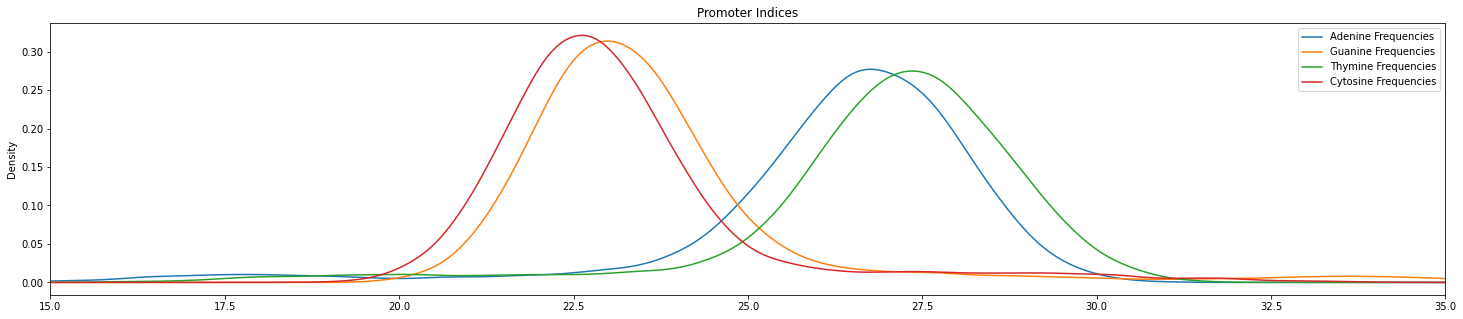

In [12]:
plt.figure()
frequency_df.plot.density(figsize = (25, 5), title = 'Promoter Indices', xlim = (15, 35))

## Preview the dataframe

In [13]:
dna_df.head(n = 20)

,Promoter-Index,"Nuc(0, 0)","Nuc(0, 1)","Nuc(0, 2)","Nuc(0, 3)","Nuc(1, 0)","Nuc(1, 1)","Nuc(1, 2)","Nuc(1, 3)","Nuc(2, 0)","Nuc(2, 1)","Nuc(2, 2)","Nuc(2, 3)","Nuc(3, 0)","Nuc(3, 1)","Nuc(3, 2)","Nuc(3, 3)","Nuc(4, 0)","Nuc(4, 1)","Nuc(4, 2)","Nuc(4, 3)","Nuc(5, 0)","Nuc(5, 1)","Nuc(5, 2)","Nuc(5, 3)","Nuc(6, 0)","Nuc(6, 1)","Nuc(6, 2)","Nuc(6, 3)","Nuc(7, 0)","Nuc(7, 1)","Nuc(7, 2)","Nuc(7, 3)","Nuc(8, 0)","Nuc(8, 1)","Nuc(8, 2)","Nuc(8, 3)","Nuc(9, 0)","Nuc(9, 1)","Nuc(9, 2)",...,"Nuc(290, 0)","Nuc(290, 1)","Nuc(290, 2)","Nuc(290, 3)","Nuc(291, 0)","Nuc(291, 1)","Nuc(291, 2)","Nuc(291, 3)","Nuc(292, 0)","Nuc(292, 1)","Nuc(292, 2)","Nuc(292, 3)","Nuc(293, 0)","Nuc(293, 1)","Nuc(293, 2)","Nuc(293, 3)","Nuc(294, 0)","Nuc(294, 1)","Nuc(294, 2)","Nuc(294, 3)","Nuc(295, 0)","Nuc(295, 1)","Nuc(295, 2)","Nuc(295, 3)","Nuc(296, 0)","Nuc(296, 1)","Nuc(296, 2)","Nuc(296, 3)","Nuc(297, 0)","Nuc(297, 1)","Nuc(297, 2)","Nuc(297, 3)","Nuc(298, 0)","Nuc(298, 1)","Nuc(298, 2)","Nuc(298, 3)","Nuc(299, 0)","Nuc(299, 1)","Nuc(299, 2)","Nuc(299, 3)"
0,203,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,236,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,109,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,77,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,208,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
5,69,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
6,58,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
7,158,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
8,136,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
9,156,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,...,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


## Preview the Negative Data set

In [14]:
neg_dna_df.head(n = 20)

,Promoter-Index,"Nuc(0, 0)","Nuc(0, 1)","Nuc(0, 2)","Nuc(0, 3)","Nuc(1, 0)","Nuc(1, 1)","Nuc(1, 2)","Nuc(1, 3)","Nuc(2, 0)","Nuc(2, 1)","Nuc(2, 2)","Nuc(2, 3)","Nuc(3, 0)","Nuc(3, 1)","Nuc(3, 2)","Nuc(3, 3)","Nuc(4, 0)","Nuc(4, 1)","Nuc(4, 2)","Nuc(4, 3)","Nuc(5, 0)","Nuc(5, 1)","Nuc(5, 2)","Nuc(5, 3)","Nuc(6, 0)","Nuc(6, 1)","Nuc(6, 2)","Nuc(6, 3)","Nuc(7, 0)","Nuc(7, 1)","Nuc(7, 2)","Nuc(7, 3)","Nuc(8, 0)","Nuc(8, 1)","Nuc(8, 2)","Nuc(8, 3)","Nuc(9, 0)","Nuc(9, 1)","Nuc(9, 2)",...,"Nuc(290, 0)","Nuc(290, 1)","Nuc(290, 2)","Nuc(290, 3)","Nuc(291, 0)","Nuc(291, 1)","Nuc(291, 2)","Nuc(291, 3)","Nuc(292, 0)","Nuc(292, 1)","Nuc(292, 2)","Nuc(292, 3)","Nuc(293, 0)","Nuc(293, 1)","Nuc(293, 2)","Nuc(293, 3)","Nuc(294, 0)","Nuc(294, 1)","Nuc(294, 2)","Nuc(294, 3)","Nuc(295, 0)","Nuc(295, 1)","Nuc(295, 2)","Nuc(295, 3)","Nuc(296, 0)","Nuc(296, 1)","Nuc(296, 2)","Nuc(296, 3)","Nuc(297, 0)","Nuc(297, 1)","Nuc(297, 2)","Nuc(297, 3)","Nuc(298, 0)","Nuc(298, 1)","Nuc(298, 2)","Nuc(298, 3)","Nuc(299, 0)","Nuc(299, 1)","Nuc(299, 2)","Nuc(299, 3)"
0,x,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
1,x,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1
2,x,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0
3,x,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4,x,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
5,x,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
6,x,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0
7,x,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0
8,x,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
9,x,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


## Comparison of Dataframe and Neg-Dataframe
* Verify the negative dataset was generated properly

In [15]:
dna_df.compare(neg_dna_df)

Promoter-Index       Nuc(0, 0)        ... Nuc(284, 2)       Nuc(284, 3)      
               self other      self other  ...        self other        self other
0               203     x       NaN   NaN  ...         NaN   NaN         NaN   NaN
1               236     x       1.0   0.0  ...         NaN   NaN         NaN   NaN
2               109     x       NaN   NaN  ...         NaN   NaN         NaN   NaN
3                77     x       NaN   NaN  ...         1.0   0.0         NaN   NaN
4               208     x       NaN   NaN  ...         NaN   NaN         0.0   1.0
...             ...   ...       ...   ...  ...         ...   ...         ...   ...
1832            225     x       NaN   NaN  ...         NaN   NaN         NaN   NaN
1833            197     x       NaN   NaN  ...         NaN   NaN         NaN   NaN
1834             62     x       1.0   0.0  ...         1.0   0.0         0.0   1.0
1835            152     x       NaN   NaN  ...         NaN   NaN         NaN   NaN
1836             81     x       NaN   NaN  ...         NaN   NaN         NaN   NaN

[1837 rows x 2282 columns]

# FREQUENCY DATAFRAME INFORMATION

---




## Printing frequency data frame

In [16]:
frequency_df.head(n=10500)

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
0,27.381600,23.462167,26.292869,22.863364
1,27.544910,22.427872,27.925966,22.101252
2,28.579205,22.318998,27.544910,21.556886
3,25.367447,24.605335,26.183996,23.843223
4,26.891671,21.665759,27.925966,23.516603
...,...,...,...,...
10495,20.794774,29.613500,24.496462,25.095264
10496,23.407730,27.871530,23.571040,25.149701
10497,20.032662,30.212303,22.591181,27.163854
10498,21.829069,28.089276,23.788786,26.292869


## Describing Frequency data frame

In [17]:
frequency_df.describe()

,Adenine Frequencies,Guanine Frequencies,Thymine Frequencies,Cytosine Frequencies
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,26.251453,23.675031,26.934346,23.139171
std,2.278417,2.340623,2.159434,1.966093
min,8.002177,16.276538,2.994012,18.290691
25%,25.639630,22.427872,26.238432,21.992379
50%,26.619488,23.189984,27.272727,22.808928
75%,27.544910,24.115406,28.198149,23.679913
max,44.039194,39.085465,32.716385,50.081655


# SUBSEQUENCE DATAFRAME INFORMATION

---



## Printing Subsequence DataFrame

In [18]:
subsequence_df.head(n=20)

,Sub-Sequences,Promoter-Index,SequenceStart,SequenceEnd
0,"(G, C, A, G, G, G, G, C, T, G, C, T, G, C, T, ...",203,9797,10097
1,"(G, G, A, C, A, G, G, G, C, G, A, C, T, T, C, ...",236,9764,10064
2,"(T, G, G, T, G, G, A, G, T, G, G, G, A, A, C, ...",109,9891,10191
3,"(G, G, G, G, G, C, G, G, T, G, C, C, T, A, G, ...",77,9923,10223
4,"(A, A, C, C, T, G, G, A, G, G, C, T, G, T, T, ...",208,9792,10092
5,"(G, G, A, G, A, A, T, T, C, C, T, C, A, C, A, ...",69,9931,10231
6,"(T, T, C, A, C, C, T, T, A, T, T, T, G, C, A, ...",58,9942,10242
7,"(A, G, T, A, G, C, T, A, C, G, G, T, A, A, T, ...",158,9842,10142
8,"(G, G, G, C, G, G, G, G, G, C, G, G, G, G, C, ...",136,9864,10164
9,"(C, A, A, T, C, A, A, A, A, C, A, A, T, G, A, ...",156,9844,10144


## Describing the subsequence dataframe

In [19]:
print('Index frequencies:')
print(subsequence_df['Promoter-Index'].value_counts())

Index frequencies:
62     19
87     19
205    18
121    16
188    16
       ..
84      4
198     3
237     3
59      3
82      3
Name: Promoter-Index, Length: 200, dtype: int64


## Density plot of subsequence dataframe

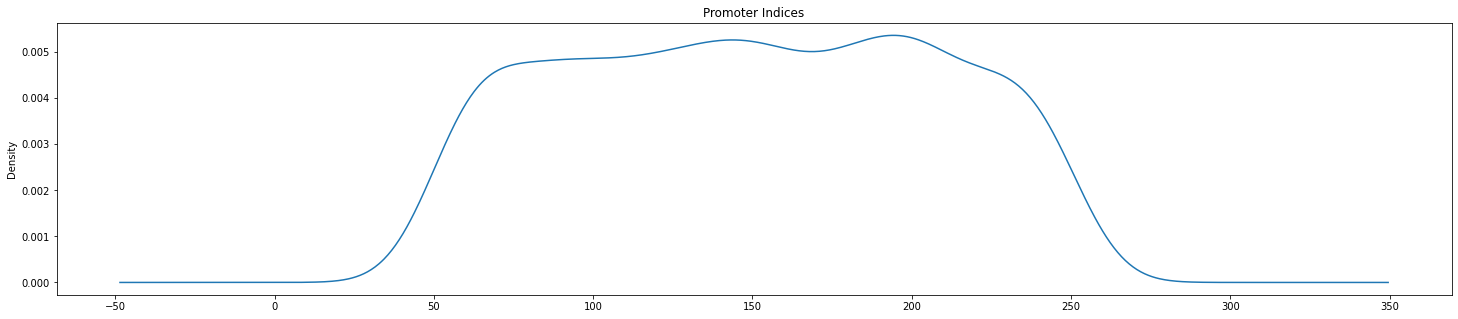

In [20]:
plt.figure()
subsequence_df['Promoter-Index'].plot.density(figsize = (25, 5), title = 'Promoter Indices')

# Arranging features and labels

In [23]:
X = dna_df.loc[:, 'Nuc(0, 0)' : 'Nuc(299, 0)'].to_numpy()
y = dna_df.loc[:, 'Promoter-Index'].to_numpy()

print("Features: \n")
print(X)

print("Labels: \n")
print(y)

Features: 

[[1 0 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 1 0 1]]
Labels: 

[203 236 109 ...  62 152  81]


## Constructing PyTorch Dataset

In [38]:
import torch
from torch.utils.data import Dataset, random_split

class Sequences(Dataset):
    def __init__(self, X, y):
        self.sequences = torch.from_numpy(X) # convert numpy arrays to torch tensors
        self.labels = torch.from_numpy(y)

        self.sequences = self.sequences.unsqueeze(1) # add extra dimension for torch
        self.labels = self.labels.unsqueeze(1)

    def __len__(self):
        assert len(self.sequences) == len(self.labels) # ensure 1-to-1 correspondence
        print('hello world')
        return len(self.labels)

    def __getitem__(self, i):
        return self.sequences[i], self.labels[i] # return X, y pair

data = Sequences(X, y)
trainCount = int(0.8 * len(data)) # percent of our data for train
train, test = random_split(data, [trainCount, len(data) - trainCount])
train[0]

hello world
hello world
hello world


(tensor([[0, 0, 1,  ..., 1, 0, 0]]), tensor([96]))

# Model Construction

### General Idea:
* Input
  * a sequence of 300 base pairs
* Next section:
  * Multiple Parallel Convolutional Layers
* Next section: 
  * BiLSTM
* Final section:
  * Fully-Connected Dense Net for promoter location prediction

### Detailed Idea:
* Input
  * a sequence of 300 base pairs
* Convolutional section:
  * 5 Convolutional layers (stacked atop each other)
    * 3 with window/kernel size: 27, 14, 7 respectively.
    * 2 with window/kernel size: 27, 14 respectively.
  * All Convolutional layers are followed by: 
    * ReLU activation function
    * Max pooling layer with window size = 6
    * Dropout layer with p = 0.5
* BiLSTM section:
  * 32 nodes 
* Flatten section
  * With dropout with p = 0.5
* Fully-connected section:
  * 2 fully-connected layers for classification:
    * first layer has 128 nodes
      * with by ReLU activations
      * dropout with p = 0.5
    * second layer has 1 node
      * with sigmoid activation

# Optimizer
* Adam optimizer
  * lr = 0.001
  * batch size = 32
  * epochs = 50
  * **EARLY STOPPING APPLIED ON VALIDATION LOSS**



In [39]:
import torch.nn as nn
import torch.nn.functional as F


class HideAndSeq(nn.Module):
  def __init__(self):
      super().__init__()
      # define the 5 parallel convolutional layers section
      # TATA section

      #input is 1x300, 
      # 
      self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=27)
      
      self.conv3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=14)
      self.conv5 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=7)
      # Non-TATA section
      self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=27)
      self.conv4 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=14)
      # define layers following all conv layers
      self.pool = nn.MaxPool1d(kernel_size=6)
      self.dropout = nn.Dropout(p=0.5)
      
      # define the BiLSTM section

      # define the flatten section


  def forward(self, x):
    # apply ReLU activation and max pooling
    # x = x.unsqueeze(1)
    print('x.shape = ', x.shape)
    x1 = self.dropout(self.pool(F.relu(self.conv1(x))))
    print('x1.shape = ', x1.shape)
    x2 = self.dropout(self.pool(F.relu(self.conv2(x))))
    x3 = self.dropout(self.pool(F.relu(self.conv3(x))))
    x4 = self.dropout(self.pool(F.relu(self.conv4(x))))
    x5 = self.dropout(self.pool(F.relu(self.conv5(x))))
    return x


model = HideAndSeq()
feature_vector, label = train[0]
print('feature_vector = ', feature_vector)
print('label = ', label)
model.forward(feature_vector)

a =  tensor([[0, 0, 1,  ..., 1, 0, 0]])
b =  tensor([96])
x.shape =  torch.Size([1, 1197])


RuntimeError: ignored

In [ ]:
class Net(nn.Module):
      def __init__(self):
        super(Net, self).__init__()
        # Yes, it's 1x1 ... dont ask why
        self.first_layers = [nn.Linear(1, 1) for di in range(L1_NEURONS)]

        self.second_layer = nn.Linear(L1_NEURONS, 1)
        
        self.outs  = numpy.zeros((L1_NEURONS))

      def forward(self, xinput):
        sums = [self.first_layers[di](xinput) for di in range(L1_NEURONS)]
        if (di < 30):
                    self.outs[di] = torch.tanh(sums[di])
        else:
                    self.outs[di] = torch.relu(sums[di])
        return self.second_layer( self.outs)